In [15]:
%matplotlib inline
#!/home/leonard/Applications/anaconda3/bin/python
import sys, traceback
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("TkAgg")
from plantcv import plantcv as pcv

class options:
    def __init__(self):
        self.image = "img/tutorial_images/vis/original_image.jpg"
        self.debug = "plot"
        self.writeimg = True
        self.result = "./vis_tutorial_results"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


In [16]:
### Main pipeline

    # Read image
    img, path, filename = pcv.readimage("/home/leonard/Documents/Uni/PhD/Phenotyping/2019-03-26_Laccase_mutants/Trays/2019-03-29_Tray1_60.JPG")

IndexError: index 5386 is out of bounds for axis 0 with size 4016

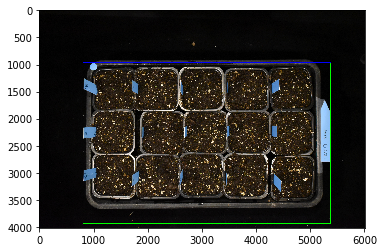

In [32]:
    #Crop tray
    #Convert RGB to HSV and extract the value channel
    h = pcv.rgb2gray_hsv(img, "v")
    # Threshold the value image
    v_thresh = pcv.threshold.binary(h, 175, 255, "light")
    v_mblur = pcv.median_blur(v_thresh, 5)
    #roi_contour, roi_hierarchy = pcv.roi.from_binary_image(img=img, bin_img=v_thresh)
    #crop_img = pcv.auto_crop(img, id_objects[0], 20, 20, 'black')
   
    x,y,w,h = cv2.boundingRect(v_mblur)
    #box = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    #cv2.drawContours(img,[box],0,(0,0,255),2)
    roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img, x=x, y=y, h=h, w=w)
    #print(roi_contour)
    crop_img = img[tuple(roi_contour)]
    
    
    #rect = cv2.minAreaRect(v_mblur)
    #box = cv2.boxPoints(rect)
    #box = np.int0(box)
    

    
    

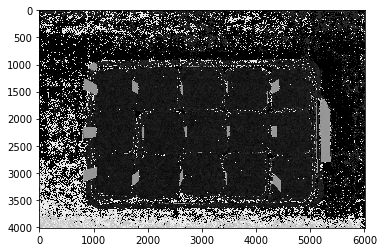

In [3]:
    # Convert RGB to HSV and extract the hue channel
    h = pcv.rgb2gray_hsv(img, "h")

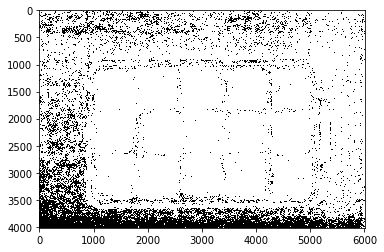

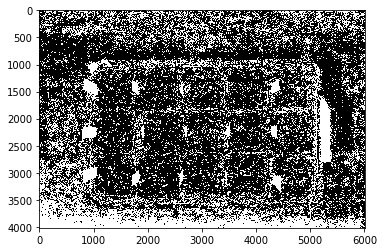

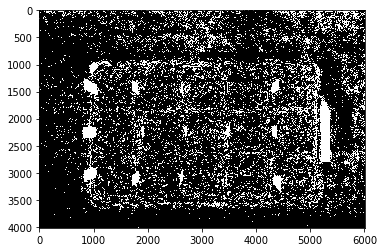

In [4]:
    # Threshold the hue image
    h_thresh1 = pcv.threshold.binary(h, 110, 255, "dark")
    h_thresh2 = pcv.threshold.binary(h, 20, 255, "light")
    h_thresh = pcv.logical_and(h_thresh1, h_thresh2)

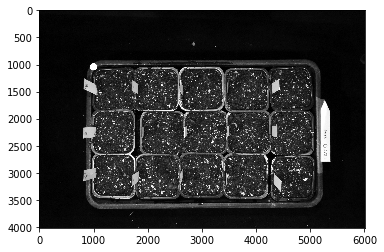

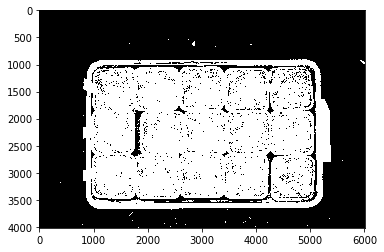

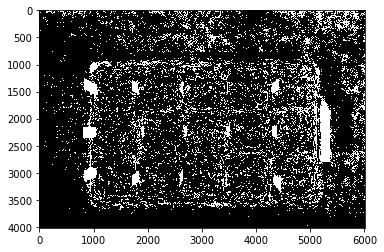

In [7]:
    # Median Blur
    h_mblur = pcv.median_blur(h_thresh, 5)
    #h_cnt = pcv.median_blur(h_thresh, 5)

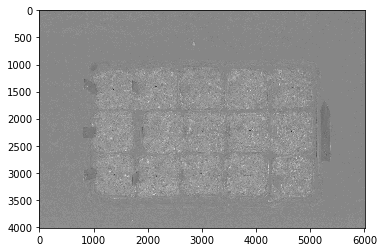

In [8]:
    # Convert RGB to LAB and extract the Blue channel
    b = pcv.rgb2gray_lab(img, "a")

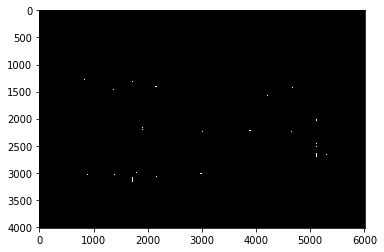

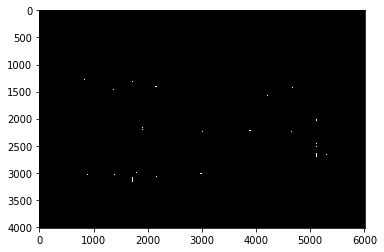

In [9]:
    # Threshold the blue image
    b_thresh = pcv.threshold.binary(b, 120, 255, "dark")
    b_cnt = pcv.threshold.binary(b, 120, 255, "dark")

In [10]:
   # Join the thresholded saturation and blue-yellow images
    #bh = pcv.logical_or(h_mblur, b_cnt)
    bh = b_cnt

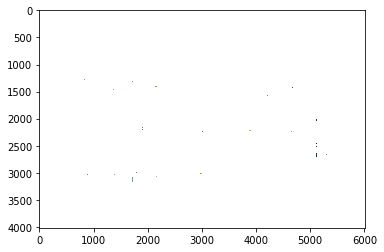

In [11]:
    # Apply Mask (for VIS images, mask_color=white)
    masked = pcv.apply_mask(img, bh, "white")

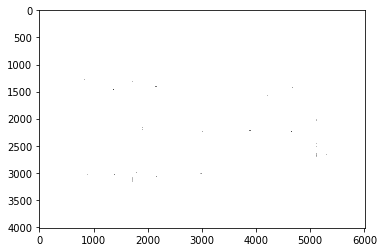

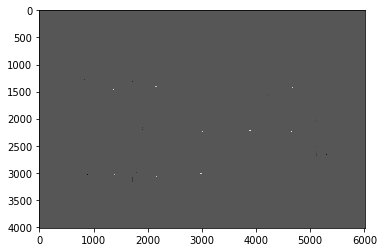

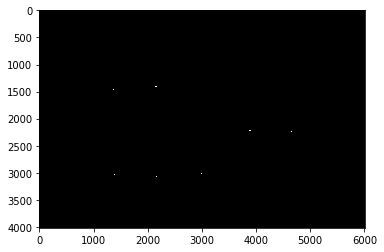

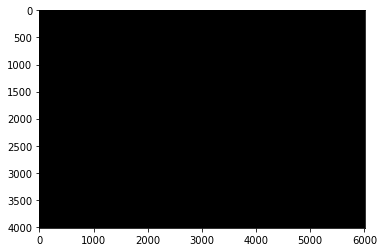

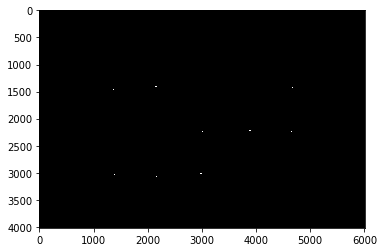

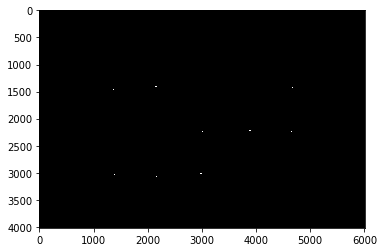

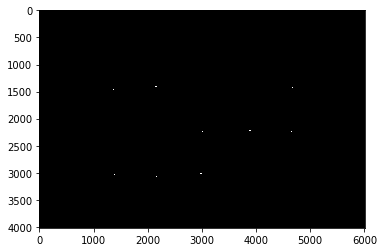

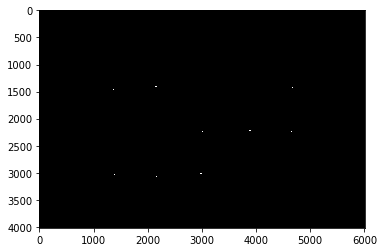

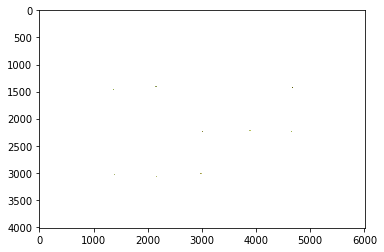

In [12]:

    # Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
    masked_a = pcv.rgb2gray_lab(masked, "a")
    masked_b = pcv.rgb2gray_lab(masked, "b")

    # Threshold the green-magenta and blue images
    maskeda_thresh = pcv.threshold.binary(masked_a, 115, 255, "dark")
    maskeda_thresh1 = pcv.threshold.binary(masked_a, 135, 255, "light")
    maskedb_thresh = pcv.threshold.binary(masked_b, 128, 255, "light")

    # Join the thresholded saturation and blue-yellow images (OR)
    ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh)
    ab = pcv.logical_or(maskeda_thresh1, ab1)

    # Fill small objects
    ab_fill = pcv.fill(ab, 200)

    # Apply mask (for VIS images, mask_color=white)
    masked2 = pcv.apply_mask(masked, ab_fill, "white")

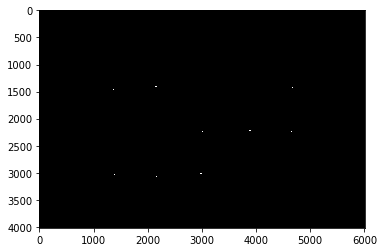

In [13]:
# STEP 8: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img    = input image
#    kernel = integer
#    i      = iterations, i.e. number of consecutive filtering passes

dilated = pcv.dilate(ab_fill, 1, 1)

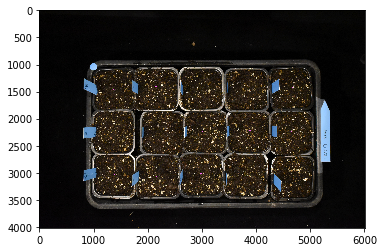

In [14]:
# STEP 9: Find objects (contours: black-white boundaries)
# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection

id_objects, obj_hierarchy = pcv.find_objects(img, dilated)

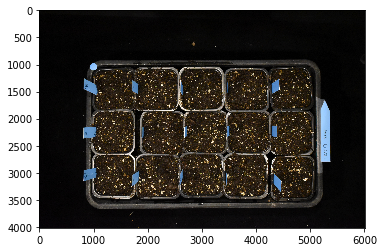

In [15]:
# STEP 10: Define region of interest (ROI)
# Inputs:
#    x     = The x-coordinate of the upper left corner of the rectangle.
#    y     = The y-coordinate of the upper left corner of the rectangle.
#    w     = The height of the rectangle.
#    h     = The width of the rectangle.
#    img   = An RGB or grayscale image to plot the ROI on.
#    roi_contour, roi_hierarchy = pcv.roi.rectangle(5, 90, 200, 390, img1)                                                ^                ^
#                                                  |______________|
#                                            adjust these four values

roi_contour, roi_hierarchy = pcv.roi.rectangle(0, 0, 3000, 3800, img)

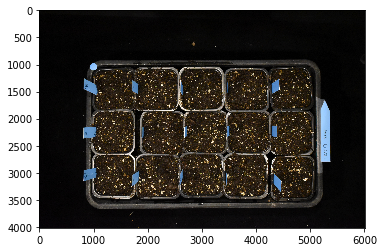

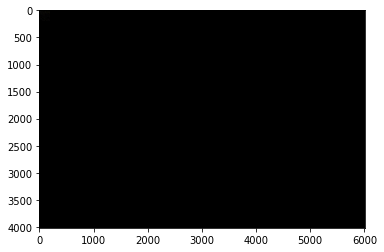

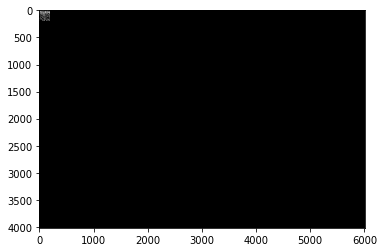

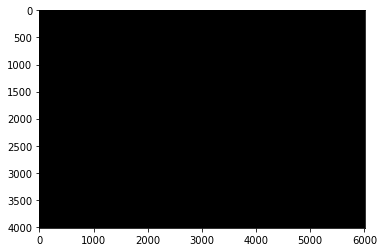

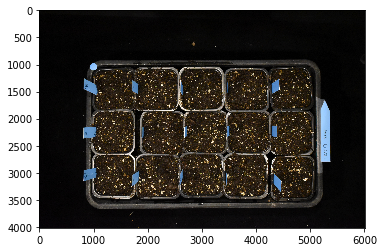

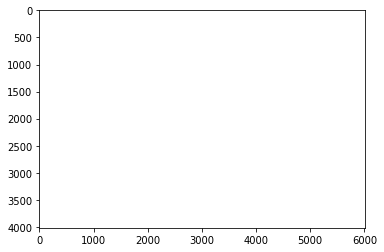

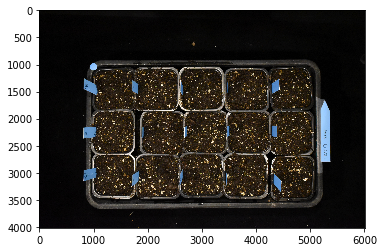

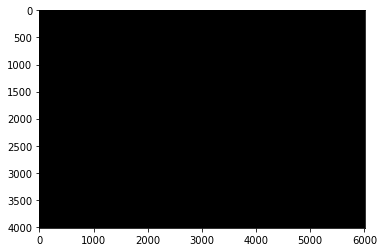

error: /feedstock_root/build_artefacts/opencv_1489510843930/work/opencv-3.1.0/modules/imgproc/src/shapedescr.cpp:345: error: (-215) n >= 0 && (depth == CV_32F || depth == CV_32S) in function fitEllipse


In [16]:
# STEP 11 (optional): Get the size of the marker. First make a region of interest around one of 
# the toughspots. Then use `report_size_marker_area`. 

marker_contour, marker_hierarchy = pcv.roi.rectangle(0,0,200,200, img)

# Inputs:
#   img - RGB or grayscale image to plot the marker object on 
#   roi_contour = A region of interest contour 
#   roi_hierarchy = A region of interest contour heirarchy 
#   marker = 'define' (default) or 'detect', if 'define' then you set an area, if 'detect'
#            it means you want to detect within an area 
#   objcolor = Object color is 'dark' (default) or 'light', is the marker darker or lighter than 
#               the background?
#   thresh_channel = 'h', 's', 'v' for hue, saturation, or value. Default set to None. 
#   thresh = Binary threshold value (integer), default set to None 
#   
marker_header, marker_data, analysis_images = pcv.report_size_marker_area(
    img, marker_contour, marker_hierarchy, marker='detect', objcolor='light', 
    thresh_channel='v', thresh=230)
print(marker_data)

In [ ]:
# STEP 12: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi_contour, roi_hierarchy,
                                                                      id_objects, obj_hierarchy)

In [ ]:
# STEP 13: This function take a image with multiple contours and
# clusters them based on user input of rows and columns

# Inputs:
#    img               = An RGB image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of desired columns in the entire image even if there isn't a literal row of plants)

clusters_i, contours, hierarchies = pcv.cluster_contours(img, roi_objects, roi_obj_hierarchy, 4, 5)

In [ ]:
# STEP 14: This #function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered
# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
# Un-comment the line below to see the split up contours print to the output directory 
#pcv.params.debug = "print"

out = args.outdir

# If you have a list of treatments, genotypes, etc. You would input a .txt file with them to help save
# the contours by names, add it to the options class and then add filenames=names to the 
# splitimg function below.  
#names = args.names

output_path = pcv.cluster_contour_splitimg(img, clusters_i, contours, 
                                           hierarchies, out, file=filename)